# Set Up

In [1]:
from __future__ import print_function
from six.moves import zip, range
import pandas as pd # Handle dataframes
pd.set_option('display.max_columns', None) # Per visualizzare tutte le colonne di un dataset, display(df)
#pd.set_option('display.max_rows', None)   # Per visualizzare tutte le righe di un dataset, display(df)

import recordlinkage
from recordlinkage.preprocessing import clean

import sys
sys.path.append('/Users/mattia/Desktop/MatchAnalysis_Imputation/Progetto/Funzioni')
from funzioni import record_linkage_title,record_linkage_city_title

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Disable future warnings


path_data_product = "/Users/mattia/Desktop/MatchAnalysis_Imputation/Progetto/Data Product"
path_risultati = "/Users/mattia/Desktop/MatchAnalysis_Imputation/Progetto/Results"

In [2]:
agoda = pd.read_csv(f"{path_data_product}/agoda.csv",index_col=0)
booking = pd.read_csv(f"{path_data_product}/booking.csv",index_col=0)

In [3]:
display(agoda.head(1))
display(booking.head(1))

,titolo,titolo_processed,zona,zona_processed,città,distanza_centro,prezzo,numero_notti,numero_persone,inizio_permanenza,fine_permanenza,recensione_voto_numerico,recensione_voto_parola,numero_recensioni,date,permanenza,indirizzo,valutazione,inizio_permanenza_datetime,fine_permanenza_datetime
0,Raeli Hotel Lazio,Hotel Lazio Raeli,Stazione centrale Roma Termini,stazione termini,roma,0.0,159,1.0,2.0,01-08-25,02-08-25,"7,7",Ottimo,321.0,1 agosto - 2 agosto,"1 notte, 2 adulti","Stazione centrale Roma Termini, Roma - In pien...",3.0,2025-01-08,2025-02-08


,titolo,titolo_processed,zona,zona_processed,città,distanza_centro,prezzo,numero_notti,numero_persone,inizio_permanenza,fine_permanenza,recensione_voto_numerico,recensione_voto_parola,numero_recensioni,date,permanenza,indirizzo,valutazione_booking,stelle,descrizione_camera,configurazione_camera,descrizione_unprocessed,inizio_permanenza_datetime,fine_permanenza_datetime
0,The Sereno-3,3 Sereno The,Trionfale,trionfale,roma,3.5,242,1,2,01-08-25,02-08-25,"8,1",Ottimo,10,1 agosto - 2 agosto,"1 notte, 2 adulti","Trionfale, Roma",4.0,NaN,Appartamento con 2 Camere da Letto e Vista Città,Intero appartamento • 2 camere da letto • 1 ba...,Appartamento con 2 Camere da Letto e Vista Cit...,2025-01-08,2025-02-08


# Record Linkage basato esclusivamente sulla variabile TITOLO utilizzando vari thresholds

### Record linkage su titolo, threshold = 0.95

Per prima cosa un passaggio nel quale si performa ancora una piccolo cleaning sui dati.   
- Si pulisce la variabile **titolo_processed** utilizzando la funzione **clean** del pacchetto *recordlinkage*;
- Si crea una variabile **first_letter** che sarà poi utile per le strategie di **blocking**.

Inoltre si crea una copia dei dataset originali **booking** ed **agoda** per non avere problemi.

In [4]:
copia_booking = booking.copy()
copia_agoda = agoda.copy()
soglia = 0.95

# Aggiungere le colonne ID: 
copia_booking['id_booking'] = copia_booking.index
copia_agoda['id_agoda'] = copia_agoda.index

copia_booking = copia_booking.rename(columns={"titolo_processed":"titolo_booking"})
copia_agoda = copia_agoda.rename(columns={"titolo_processed":"titolo_agoda"})

# Blocking sulla prima lettera (Il blocking sulla prima lettera è una tecnica di record linkage usata per ridurre il numero di confronti tra record che devono essere effettuati.)
#  Nel record linkage, si confrontano record da due (o più) set di dati per trovare duplicati o corrispondenze. Confrontare ogni record con tutti gli altri è computazionalmente costoso, soprattutto con set grandi complessità. 
# Il blocking serve a limitare i confronti a gruppi più piccoli di record che condividono una certa caratteristica.
# Il blocking sulla prima lettera: significa che i record vengono suddivisi in blocchi in base alla prima lettera di un campo di testo, per esempio un cognome, un nome o un indirizzo. Solo i record che iniziano con la stessa lettera vengono poi confrontati tra loro.
copia_booking['first_letter'] = copia_booking['titolo_booking'].str[0]
copia_agoda['first_letter'] = copia_agoda['titolo_agoda'].str[0]

Iniziare con il record linkage.
Il record linkage viene diviso in 5 steps:
   1. Definire strategia di blocking;

   2. Generare candidate pairs secondo le regole di blocking dello step1;

   3. Configurare il metodo per il calcolo delle similarità;

   4. Calcolo delle similarità;

   5. Tramite threshold identificare match;

   6. Aggiungere al dataframe dei match le informazioni di **agoda** e **booking**.

In [5]:
# STEP 1
# Creare un oggetto di tipo Index e  definire una strategia di "blocking" basata sul valore della colonna 'first_letter'.
indexer = recordlinkage.Index() # Creare index
indexer.block('first_letter')   # Definire il blocking sulla prima lettera (utilizzare variabile 'first_letter')

# STEP 2
# Generare i candidate pairs (coppie da confrontare) tra due dataset (copia_booking e copia_agoda), 
# secondo le regole di blocking definite prima con indexer.block() (step 1).
candidate_links = indexer.index(copia_booking, copia_agoda) # Trovare le coppie da confrontare 
print(f"Coppie candidate: {len(candidate_links)}")          # Mostrare a schermo il numero di coppie candidate

# STEP 3
# Configurare il confronto tra due colonne di testo, usando il metodo di similarità Jaro-Winkler.
# Il metodo Jaro-Winkler è particolarmente efficace per confrontare stringhe brevi e con piccole variazioni o errori di battitura (es. "Hotel Roma" vs "Hotel Roma Center").
compare = recordlinkage.Compare()
compare.string('titolo_booking',         # variabile 1 da confrontare
               'titolo_agoda',           # variabile 2 da confrontare
               method='jarowinkler',    # Metodo per il confronto
               label='name_similarity'  # Nome della variabile risultante contenente la simililarità, compresa tra 0 e 1 (0 stringhe completamente diverse, 1 stringhe identiche)
               )

# STEP 4
# Eseguire effettivamente il confronto tra le coppie di record (i candidate links) generate in precedenza (STEP 2).
# Usa le regole di similarità definite con compare
features = compare.compute(candidate_links, copia_booking, copia_agoda) # Restituisce un pandas dataframe con la similarity per ogni coppia
#print(features['name_similarity'].describe()) # Overview sulle similarities calcolate.

# STEP 5
# Trovare i match. Le coppie con un valore di similarità superiore a una soglia stabilita sono considerate match.
# Il metodo fellegi sunter non può essere usato su una sola variabile quindi si fa direttamente la selezione tramite soglia.
scores_df = features[features['name_similarity'] > soglia] # Estrazione coppie match
# Ordinare il dataset dei risultati. Aggiungere ai match le informazioni di agoda e booking
scores_df.reset_index(inplace=True)  # Fare il reset degli indici. In questo modo si avranno come variabili gli indici delle location. 
                                 # Avere gli indici come variabili faciliterà poi  le prossime operazioni.                                  
scores_df = scores_df.rename(columns={'level_0': 'index_booking', 'level_1': 'index_agoda'}) # Rinominare le variabili indice
scores_df['pair'] = scores_df['index_booking'].astype(str) + '#' + scores_df['index_agoda'].astype(str)

# Negli step successivi:
# A. Eliminati tutti gli index che hanno più di un match
# B. Selezionato solo l'index booking duplicato con score maggiore, a parità presi entrambi
# C. Selezionato solo l'index agoda duplicato con score maggiore, a parità presi entrambi
# D. Inserire nuovamente i match migliori.
# In questo modo se una location ha più di un match si prende quella con la probabilità di match migliore
# è infatti inutile avere due match diversi dato che uno sarà sicuramente sbagliato dato che la corrispondenza deve
# essere 1:1
match = scores_df.copy()


# A. Prendere solo il match migliore per ogni location, non ha senso prendere la seconda opzione.
match = scores_df.drop_duplicates(subset='index_booking', keep=False)
match = match.drop_duplicates(subset='index_agoda', keep=False)

# B.
# Filtra solo i duplicati su index_booking
dups = scores_df[scores_df.duplicated(subset='index_booking', keep=False)]
# Raggruppa per index_booking e seleziona il massimo score
booking_best_match = dups.groupby('index_booking', group_keys=False).apply(
    lambda row: row[row['name_similarity'] == row['name_similarity'].max()]
)

# C.
# Filtra solo i duplicati su index_agoda
dups = scores_df[scores_df.duplicated(subset='index_agoda', keep=False)]
# Raggruppa per index_booking e seleziona il massimo score
agoda_best_match = dups.groupby('index_agoda', group_keys=False).apply(
    lambda row: row[row['name_similarity'] == row['name_similarity'].max()]
)

# D.
agoda_best_match["pair"] = agoda_best_match['index_booking'].astype(str) + '#' + agoda_best_match['index_agoda'].astype(str)
booking_best_match["pair"] = booking_best_match['index_booking'].astype(str) + '#' + booking_best_match['index_agoda'].astype(str)
match = pd.concat([match,booking_best_match])
match = pd.concat([match,agoda_best_match])


# STEP 6
# Lista delle variabili da inserire nel dataset finale dei match. 
# Evito di inserie numero di notti e persone perchè è lo stesso per entrambi i dataset. E quindi si prende direttamente dall'ultimo dataset
variabili_comuni = ["titolo","zona","città","distanza_centro","prezzo", 
                    'recensione_voto_numerico','recensione_voto_parola','numero_recensioni'] 

# Unire il dataframe dei match con il dataframe booking. Prendere solo le informazioni delle accomodation in comune.
match = pd.merge(match, # Dataframe left
                 booking[variabili_comuni], # Dataframe right
                 left_on="index_booking",   # Il dataframe left (match) ha come indice per il merge la variabile 'index_booking'
                 right_index=True # Il dataframe right (booking) ha come indice per il merge l'index.
                 ) 

variabili_comuni.extend(['numero_notti', 'numero_persone', 'inizio_permanenza', 'fine_permanenza']) # Ora posso aggiungere le variabili comuni.
match =  pd.merge(match, # Dataframe left
                 agoda[variabili_comuni], # Dataframe right
                 left_on="index_agoda", # Il dataframe left (match) ha come indice per il merge la variabile 'index_booking'
                 right_index=True, # Il dataframe right (booking) ha come indice per il merge l'index.
                 suffixes=("_booking","_agoda") # Le variabili che avranno nome uguali in left e right avranno suffisso 'booking' in left e suffisso 'agoda' in right
                 ) 

                                                                     
# Ordinare le colonne per una visualizzazione dei dati migliore.
match = match[[ 'pair','name_similarity',
               'titolo_booking', 'titolo_agoda',
               'zona_booking','zona_agoda',
               'città_booking', 'città_agoda',
               'prezzo_booking', 'prezzo_agoda', 
               'index_booking', 'index_agoda',
               'distanza_centro_booking', 'distanza_centro_agoda',
               'recensione_voto_numerico_booking', 'recensione_voto_numerico_agoda',
               'recensione_voto_parola_booking',    'recensione_voto_parola_agoda',
               'numero_recensioni_booking','numero_recensioni_agoda',
               'numero_notti', 'numero_persone', 'inizio_permanenza', 'fine_permanenza', 
            ]]
match.drop_duplicates(inplace=True) # Rimuovere righe duplicate
match

Coppie candidate: 67915


,pair,name_similarity,titolo_booking,titolo_agoda,zona_booking,zona_agoda,città_booking,città_agoda,prezzo_booking,prezzo_agoda,index_booking,index_agoda,distanza_centro_booking,distanza_centro_agoda,recensione_voto_numerico_booking,recensione_voto_numerico_agoda,recensione_voto_parola_booking,recensione_voto_parola_agoda,numero_recensioni_booking,numero_recensioni_agoda,numero_notti,numero_persone,inizio_permanenza,fine_permanenza
0,1#6,1.0,Sonder by Marriott Bonvoy Piazza Venezia Apart...,Sonder by Marriott Bonvoy Piazza Venezia Apart...,Pantheon,Pantheon,roma,roma,322,228,1,6,0.15,0.0,"8,1","9,2",Ottimo,Eccezionale,321,4.0,1.0,2.0,01-08-25,02-08-25
1,3#391,1.0,ASTORIA GOLDEN GATE,ASTORIA GOLDEN GATE,Stazione Termini,Stazione centrale Roma Termini,roma,roma,110,110,3,391,2.00,0.0,"8,9","9,1",Favoloso,Eccezionale,1446,1512.0,1.0,2.0,01-08-25,02-08-25
2,17#288,1.0,Suite Art Navona,Suite Art Navona,Piazza Navona,Piazza Navona,roma,roma,162,162,17,288,1.00,0.0,"8,1","8,2",Ottimo,Fantastico,1176,1295.0,1.0,2.0,01-08-25,02-08-25
3,27#487,1.0,Terrace Pantheon Relais,Terrace Pantheon Relais,Pantheon,Pantheon,roma,roma,366,366,27,487,0.50,0.0,"9,3","9,2",Eccellente,Eccezionale,907,1286.0,1.0,2.0,01-08-25,02-08-25
4,29#535,1.0,Hotel Fiori,Hotel Fiori,Rione Monti,Monti,roma,roma,150,150,29,535,0.40,0.0,"8,6","8,3",Favoloso,Fantastico,718,1572.0,1.0,2.0,01-08-25,02-08-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,709#71,1.0,Hotel Genio,Genio Hotel,Piazza Navona,Piazza Navona,roma,roma,213,146,709,71,1.00,0.0,"7,7","8,3",Buono,Fantastico,530,432.0,1.0,2.0,01-08-25,02-08-25
215,800#439,1.0,Grand Hotel Palace Rome,Grand Hotel Palace Rome,Via Veneto,Via Veneto,roma,roma,332,332,800,439,1.40,0.0,"8,4","8,6",Ottimo,Fantastico,673,50.0,1.0,2.0,01-08-25,02-08-25
252,851#575,1.0,San Francesco Home,San Francesco Home,Terni,Terni,terni,terni,84,84,851,575,0.40,NaN,"8,8","9,4",Favoloso,Eccezionale,17,10.0,1.0,2.0,01-08-25,02-08-25
102,433#440,1.0,Hotel Valadier,Hotel Valadier,Spagna,Piazza di Spagna,roma,roma,249,206,433,440,1.50,0.0,"8,3","8,6",Ottimo,Fantastico,2733,3009.0,1.0,2.0,01-08-25,02-08-25


In [6]:
match.to_csv(f"{path_risultati}/matches_titolo_095.csv")

### record linkage sul titolo 0.955

Tutto il codice per la sezione precedente è stato inserito in una funzione per essere richiamato più facilemente e con soglia diversa.       
Ovviamente non si tratta di una vera e propria funzione in quanto i parametri sono molti e non tutti selezionabili, è solo un modo per risparmiare codice e rendere tutto più chiaro e semplice.

In [7]:
output_0955 = record_linkage_title( copia_agoda=agoda.copy(),     #.copy() fondamentale. Essendo i pd.DataFrame() mutable si potrebbero creare errori.
                                                                  # Infatti senza .copy() agoda subirebbe le modifiche fatte dentro la funzione
                                    copia_booking= booking.copy(),
                                    soglia = 0.955           
                                 )
display(output_0955)

,pair,name_similarity,titolo_booking,titolo_agoda,zona_booking,zona_agoda,città_booking,città_agoda,prezzo_booking,prezzo_agoda,index_booking,index_agoda,distanza_centro_booking,distanza_centro_agoda,recensione_voto_numerico_booking,recensione_voto_numerico_agoda,recensione_voto_parola_booking,recensione_voto_parola_agoda,numero_recensioni_booking,numero_recensioni_agoda,numero_notti,numero_persone,inizio_permanenza,fine_permanenza
0,1#6,1.0,Sonder by Marriott Bonvoy Piazza Venezia Apart...,Sonder by Marriott Bonvoy Piazza Venezia Apart...,Pantheon,Pantheon,roma,roma,322,228,1,6,0.15,0.0,"8,1","9,2",Ottimo,Eccezionale,321,4.0,1.0,2.0,01-08-25,02-08-25
1,3#391,1.0,ASTORIA GOLDEN GATE,ASTORIA GOLDEN GATE,Stazione Termini,Stazione centrale Roma Termini,roma,roma,110,110,3,391,2.00,0.0,"8,9","9,1",Favoloso,Eccezionale,1446,1512.0,1.0,2.0,01-08-25,02-08-25
2,17#288,1.0,Suite Art Navona,Suite Art Navona,Piazza Navona,Piazza Navona,roma,roma,162,162,17,288,1.00,0.0,"8,1","8,2",Ottimo,Fantastico,1176,1295.0,1.0,2.0,01-08-25,02-08-25
3,27#487,1.0,Terrace Pantheon Relais,Terrace Pantheon Relais,Pantheon,Pantheon,roma,roma,366,366,27,487,0.50,0.0,"9,3","9,2",Eccellente,Eccezionale,907,1286.0,1.0,2.0,01-08-25,02-08-25
4,29#535,1.0,Hotel Fiori,Hotel Fiori,Rione Monti,Monti,roma,roma,150,150,29,535,0.40,0.0,"8,6","8,3",Favoloso,Fantastico,718,1572.0,1.0,2.0,01-08-25,02-08-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,883#633,1.0,"Favolosa ""Dimora del Capriolo"" con Giardino e ...","Favolosa ""Dimora del Capriolo"" con Giardino e ...",Terni,Terni,terni,terni,216,228,883,633,2.90,NaN,"9,3","9,5",Eccellente,Eccezionale,13,13.0,1.0,2.0,01-08-25,02-08-25
271,884#605,1.0,La Severa 2,La Severa 2,Terni,Terni,terni,terni,96,96,884,605,1.40,NaN,"8,4","8,4",Ottimo,Fantastico,11,11.0,1.0,2.0,01-08-25,02-08-25
272,618#359,1.0,Hotel Patria,Hotel Patria,Stazione Termini,Stazione centrale Roma Termini,roma,roma,164,125,618,359,1.20,0.0,"8,3","8,6",Ottimo,Fantastico,1669,1841.0,1.0,2.0,01-08-25,02-08-25
273,851#575,1.0,San Francesco Home,San Francesco Home,Terni,Terni,terni,terni,84,84,851,575,0.40,NaN,"8,8","9,4",Favoloso,Eccezionale,17,10.0,1.0,2.0,01-08-25,02-08-25


### Differenze tra i due thresholds titolo

In [8]:
# Modo per individuare i match diversi
#differenza_1_new = output_city_titolo_different_threshold[~output_city_titolo_different_threshold['pair'].isin(match['pair'])]
match_diversi = list(set(match.pair).difference(set(output_0955.pair)))
print(f"Numero di match diversi: {len(match_diversi)}")


match_diversi_df = match[match["pair"].isin(match_diversi)]
print(match_diversi_df.shape)
display(match_diversi_df)

Numero di match diversi: 0
(0, 24)


,pair,name_similarity,titolo_booking,titolo_agoda,zona_booking,zona_agoda,città_booking,città_agoda,prezzo_booking,prezzo_agoda,index_booking,index_agoda,distanza_centro_booking,distanza_centro_agoda,recensione_voto_numerico_booking,recensione_voto_numerico_agoda,recensione_voto_parola_booking,recensione_voto_parola_agoda,numero_recensioni_booking,numero_recensioni_agoda,numero_notti,numero_persone,inizio_permanenza,fine_permanenza


Osservando le differenze tra i match ottenuti tramite threshold posto a 0.95 e a 0.955 si può notare come aumentando la soglia di decisione
i match diventano più precisi.      

Con threshold a 0.95 Hotel Labelle ed Hotel Lella vengono matchati anche se sono hotel diversi, con threshold a 0.955 vengono **correttamente** distinti.

# Record linkage su titolo + città

### Record linkage città - titolo. Threshold titolo a 0.95

Iniziare con il record linkage, dopo una breve fase di preprocessing
Il record linkage viene diviso in 7 steps:
   1. Definire strategia di blocking;

   2. Generare candidate pairs secondo le regole di blocking dello step1;

   3. Configurare il metodo per il calcolo delle similarità;

   4. Calcolo delle similarità;

   5. Preparare dati  (binarizzazione) per l'ECMClassifier (Fellegi-Sunter);

   6. Tramite ECMClassifier (Fellegi-Sunter) identificare match;

   7. Aggiungere al dataframe dei match le informazioni di **agoda** e **booking**.

In [9]:
copia_booking = booking.copy()
copia_agoda = agoda.copy()

# Aggiungere le colonne ID: 
copia_booking['id_booking'] = copia_booking.index
copia_agoda['id_agoda'] = copia_agoda.index

copia_booking = copia_booking.rename(columns={"titolo_processed":"titolo_booking"})
copia_agoda = copia_agoda.rename(columns={"titolo_processed":"titolo_agoda"})

# Blocking sulla prima lettera (Il blocking sulla prima lettera è una tecnica di record linkage usata per ridurre il numero di confronti tra record che devono essere effettuati.)
#  Nel record linkage, si confrontano record da due (o più) set di dati per trovare duplicati o corrispondenze. Confrontare ogni record con tutti gli altri è computazionalmente costoso, soprattutto con set grandi complessità. 
# Il blocking serve a limitare i confronti a gruppi più piccoli di record che condividono una certa caratteristica.
# Il blocking sulla prima lettera: significa che i record vengono suddivisi in blocchi in base alla prima lettera di un campo di testo, per esempio un cognome, un nome o un indirizzo. Solo i record che iniziano con la stessa lettera vengono poi confrontati tra loro.
copia_booking['first_letter'] = copia_booking['titolo_booking'].str[0]
copia_agoda['first_letter'] = copia_agoda['titolo_agoda'].str[0]
copia_agoda.head(1)

,titolo,titolo_agoda,zona,zona_processed,città,distanza_centro,prezzo,numero_notti,numero_persone,inizio_permanenza,fine_permanenza,recensione_voto_numerico,recensione_voto_parola,numero_recensioni,date,permanenza,indirizzo,valutazione,inizio_permanenza_datetime,fine_permanenza_datetime,id_agoda,first_letter
0,Raeli Hotel Lazio,Hotel Lazio Raeli,Stazione centrale Roma Termini,stazione termini,roma,0.0,159,1.0,2.0,01-08-25,02-08-25,"7,7",Ottimo,321.0,1 agosto - 2 agosto,"1 notte, 2 adulti","Stazione centrale Roma Termini, Roma - In pien...",3.0,2025-01-08,2025-02-08,0,H


In [ ]:
# STEP 0, impostare i threshold/soglie
soglia_titolo = 0.95
soglia_città = 0.8

# STEP 1, strategia di blocking
indexer = recordlinkage.Index()
indexer.block('first_letter')


# STEP 2, candidate pairs
candidate_links = indexer.index(copia_booking, copia_agoda)


# STEP 3, configurare metodo per il calcolo delle similarità
compare = recordlinkage.Compare()
compare.string('titolo_booking', 'titolo_agoda', method='jarowinkler', label='name_similarity')
compare.string('città', 'città', method='jarowinkler', label='città_similarity')

# STEP 4, calcolo similarità
features = compare.compute(candidate_links, copia_booking, copia_agoda)


# STEP 5 
# Binarizzazione per Fellegi-Sunter (lascia più margine)
# Il modello si basa su variabili binarie che indicano se un certo campo matcha (coincide) o meno — o almeno supera una certa soglia di somiglianza.
# Il modello Fellegi-Sunter lavora meglio (o richiede) variabili binarie:
# Invece di usare direttamente la similarità continua (es. 0.96, 0.87...), si trasforma in vero/falso in base a una soglia ritenuta significativa.
# Questo semplifica il calcolo delle probabilità di match e non-match, che nel modello sono basate su matrici di confusione binarie (es. probabilità che name_similarity=True dato che è un match vs. non match).
features_bin = features.copy()
features_bin["name_similarity"] = features_bin["name_similarity"] > soglia_titolo
features_bin["città_similarity"] = features_bin["città_similarity"] > soglia_città

# STEP 6 Classificare tramite  ECMClassifier (Fellegi-Sunter) e trovare match.
fs = recordlinkage.ECMClassifier() # Definire il classificatore
fs.fit(features_bin)               # Train classificatore
matches = fs.predict(features_bin) # Ottenere i match

# calcola punteggio medio come proxy (media delle similarità)
scores = features.loc[list(matches)].mean(axis=1)

# Creare un dataframe con gli scores e rinominare le variabili
scores_df = scores.reset_index()
scores_df.columns = ['index_booking', 'index_agoda', 'score'] # Siccome l'ordine di confronto era booking e poi agoda, il primo indice è quello di booking, segue l'index di agoda e lo score


# Negli step successivi:
# A. Eliminati tutti gli index che hanno più di un match
# B. Selezionato solo l'index booking duplicato con score maggiore, a parità presi entrambi
# C. Selezionato solo l'index agoda duplicato con score maggiore, a parità presi entrambi
# D. Inserire nuovamente i match migliori.
# In questo modo se una location ha più di un match si prende quella con la probabilità di match migliore
# è infatti inutile avere due match diversi dato che uno sarà sicuramente sbagliato dato che la corrispondenza deve
# essere 1:1
match = scores_df.copy()


# A. Prendere solo il match migliore per ogni location, non ha senso prendere la seconda opzione.
match = scores_df.drop_duplicates(subset='index_booking', keep=False)
match = match.drop_duplicates(subset='index_agoda', keep=False)

# B.
# Filtra solo i duplicati su index_booking
dups = scores_df[scores_df.duplicated(subset='index_booking', keep=False)]

# Raggruppa per index_booking e seleziona il massimo score
booking_best_match = dups.groupby('index_booking', group_keys=False).apply(
    lambda row: row[row['score'] == row['score'].max()]
)

# C.
# Filtra solo i duplicati su index_agoda
dups = scores_df[scores_df.duplicated(subset='index_agoda', keep=False)]
# Raggruppa per index_booking e seleziona il massimo score
agoda_best_match = dups.groupby('index_agoda', group_keys=False).apply(
    lambda row: row[row['score'] == row['score'].max()]
)

# D.
agoda_best_match["pair"] = agoda_best_match['index_booking'].astype(str) + '#' + agoda_best_match['index_agoda'].astype(str)
booking_best_match["pair"] = booking_best_match['index_booking'].astype(str) + '#' + booking_best_match['index_agoda'].astype(str)
match = pd.concat([match,booking_best_match])
match = pd.concat([match,agoda_best_match])



# STEP 7, aggiungere informazioni utili ai risultati
match['pair'] = match['index_booking'].astype(str) + '#' + match['index_agoda'].astype(str)

# Lista delle variabili da inserire nel dataset finale dei match. 
# Evito di inserie numero di notti e persone perchè è lo stesso per entrambi i dataset. E quindi si prende direttamente dall'ultimo dataset
variabili_comuni = ["titolo","zona","città","distanza_centro","prezzo", 
                    'recensione_voto_numerico','recensione_voto_parola','numero_recensioni'] 

# Unire il dataframe dei match con il dataframe booking. Prendere solo le informazioni delle accomodation in comune.
match = pd.merge(match, # Dataframe left
                 booking[variabili_comuni], # Dataframe right
                 left_on="index_booking",   # Il dataframe left (match) ha come indice per il merge la variabile 'index_booking'
                 right_index=True # Il dataframe right (booking) ha come indice per il merge l'index.
                 ) 

variabili_comuni.extend(['numero_notti', 'numero_persone', 'inizio_permanenza', 'fine_permanenza']) # Ora posso aggiungere le variabili comuni.
match =  pd.merge(match, # Dataframe left
                 agoda[variabili_comuni], # Dataframe right
                 left_on="index_agoda", # Il dataframe left (match) ha come indice per il merge la variabile 'index_booking'
                 right_index=True, # Il dataframe right (booking) ha come indice per il merge l'index.
                 suffixes=("_booking","_agoda") # Le variabili che avranno nome uguali in left e right avranno suffisso 'booking' in left e suffisso 'agoda' in right
                 ) 

# Estrarre gli score della città e del titolo per poi aggiungerli al dataset finale
single_scores = features.reset_index()
single_scores["pair"] = single_scores["level_0"].astype(str) + '#' + single_scores["level_1"].astype(str)
match = pd.merge(match,single_scores,on="pair")

                                                                     
# Ordinare le colonne per una visualizzazione dei dati migliore.
match = match[[ 'pair','score','name_similarity','città_similarity',
               'titolo_booking', 'titolo_agoda',
               'zona_booking','zona_agoda',
               'città_booking', 'città_agoda',
               'prezzo_booking', 'prezzo_agoda', 
               'index_booking', 'index_agoda',
               'distanza_centro_booking', 'distanza_centro_agoda',
               'recensione_voto_numerico_booking', 'recensione_voto_numerico_agoda',
               'recensione_voto_parola_booking',    'recensione_voto_parola_agoda',
               'numero_recensioni_booking','numero_recensioni_agoda',
               'numero_notti', 'numero_persone', 'inizio_permanenza', 'fine_permanenza', 
            ]]

match.drop_duplicates(inplace=True) # Rimuovere righe duplicate totalmente
display(match.head(2))
print(match.shape)

,pair,score,name_similarity,città_similarity,titolo_booking,titolo_agoda,zona_booking,zona_agoda,città_booking,città_agoda,prezzo_booking,prezzo_agoda,index_booking,index_agoda,distanza_centro_booking,distanza_centro_agoda,recensione_voto_numerico_booking,recensione_voto_numerico_agoda,recensione_voto_parola_booking,recensione_voto_parola_agoda,numero_recensioni_booking,numero_recensioni_agoda,numero_notti,numero_persone,inizio_permanenza,fine_permanenza
0,1#6,1.0,1.0,1.0,Sonder by Marriott Bonvoy Piazza Venezia Apart...,Sonder by Marriott Bonvoy Piazza Venezia Apart...,Pantheon,Pantheon,roma,roma,322,228,1,6,0.15,0.0,"8,1","9,2",Ottimo,Eccezionale,321,4.0,1.0,2.0,01-08-25,02-08-25
1,3#391,1.0,1.0,1.0,ASTORIA GOLDEN GATE,ASTORIA GOLDEN GATE,Stazione Termini,Stazione centrale Roma Termini,roma,roma,110,110,3,391,2.00,0.0,"8,9","9,1",Favoloso,Eccezionale,1446,1512.0,1.0,2.0,01-08-25,02-08-25


(275, 26)


In [11]:
# Esportare i risultati
match.to_csv(f'{path_risultati}/matches_titolo_095_città_08.csv', index=False)

### Record linkage città - titolo. Threshold titolo a 0.95

In [12]:
output_city_titolo_different_threshold = record_linkage_city_title( dataframe_booking = booking.copy(), #.copy() fondamentale. 
                                                   # Essendo i pd.DataFrame() mutable si potrebbero creare errori.
                                                   # Infatti senza .copy() agoda subirebbe le modifiche fatte dentro la funzione
                                                   dataframe_agoda = agoda.copy(),
                                                   soglia_città = 0.9,
                                                   soglia_titolo = 0.95      
                                                )
display(output_city_titolo_different_threshold.head(2))
print(output_city_titolo_different_threshold.shape)

,pair,score,name_similarity,città_similarity,titolo_booking,titolo_agoda,zona_booking,zona_agoda,città_booking,città_agoda,prezzo_booking,prezzo_agoda,index_booking,index_agoda,distanza_centro_booking,distanza_centro_agoda,recensione_voto_numerico_booking,recensione_voto_numerico_agoda,recensione_voto_parola_booking,recensione_voto_parola_agoda,numero_recensioni_booking,numero_recensioni_agoda,numero_notti,numero_persone,inizio_permanenza,fine_permanenza
0,1#6,1.0,1.0,1.0,Sonder by Marriott Bonvoy Piazza Venezia Apart...,Sonder by Marriott Bonvoy Piazza Venezia Apart...,Pantheon,Pantheon,roma,roma,322,228,1,6,0.15,0.0,"8,1","9,2",Ottimo,Eccezionale,321,4.0,1.0,2.0,01-08-25,02-08-25
1,3#391,1.0,1.0,1.0,ASTORIA GOLDEN GATE,ASTORIA GOLDEN GATE,Stazione Termini,Stazione centrale Roma Termini,roma,roma,110,110,3,391,2.00,0.0,"8,9","9,1",Favoloso,Eccezionale,1446,1512.0,1.0,2.0,01-08-25,02-08-25


(275, 26)


### Differenze tra i due thresholds della città

Il threshold del titolo è rimasto lo stesso, è cambiato quello della città.
Con un threshold di città più alto ci sono 9 match in più, il che è strano.
Si controllino le coppie matchate diverse tra i due dataset.

In [13]:
# Un altro modo per individuare i match diversi
#differenza_1_new = output_city_titolo_different_threshold[~output_city_titolo_different_threshold['pair'].isin(match['pair'])]

match_diversi = list(set(output_city_titolo_different_threshold.pair).difference(set(match.pair)))
match_diversi

[]

In [14]:
output_city_titolo_different_threshold[output_city_titolo_different_threshold["pair"].isin(match_diversi)]

,pair,score,name_similarity,città_similarity,titolo_booking,titolo_agoda,zona_booking,zona_agoda,città_booking,città_agoda,prezzo_booking,prezzo_agoda,index_booking,index_agoda,distanza_centro_booking,distanza_centro_agoda,recensione_voto_numerico_booking,recensione_voto_numerico_agoda,recensione_voto_parola_booking,recensione_voto_parola_agoda,numero_recensioni_booking,numero_recensioni_agoda,numero_notti,numero_persone,inizio_permanenza,fine_permanenza


Modificando il threshold della città il risultato non cambia, questo accade perchè le due città prese in considerazione hanno nomi profondamente diversi, ovvero Roma e Terni.   
Con città aventi nomi più simili i risultati sarebbero potuti cambiare con threshold diversi, più o meno rigidi.

### Differenze di match tra link analysis con la sola variabile titolo e link analysis con due variabili, città e titolo

In [15]:
matches_titolo_095 = pd.read_csv(f"{path_risultati}/matches_titolo_095.csv")
matches_titolo_095_città_08 = pd.read_csv(f"{path_risultati}/matches_titolo_095_città_08.csv")

In [16]:
print(f"Numero di match con solo titolo: {matches_titolo_095.shape}")
print(f"Numero di match con titolo e città: {matches_titolo_095_città_08.shape}")

Numero di match con solo titolo: (275, 25)
Numero di match con titolo e città: (275, 26)


In [17]:
# Modo per individuare i match diversi
#differenza_1_new = output_city_titolo_different_threshold[~output_city_titolo_different_threshold['pair'].isin(match['pair'])]
match_diversi = list(set(matches_titolo_095.pair).difference(set(matches_titolo_095_città_08.pair)))
print(f"Numero di match diversi: {len(match_diversi)}")


match_diversi_df = matches_titolo_095[matches_titolo_095["pair"].isin(match_diversi)]
print(match_diversi_df.shape)
display(match_diversi_df)

Numero di match diversi: 0
(0, 25)


,Unnamed: 0,pair,name_similarity,titolo_booking,titolo_agoda,zona_booking,zona_agoda,città_booking,città_agoda,prezzo_booking,prezzo_agoda,index_booking,index_agoda,distanza_centro_booking,distanza_centro_agoda,recensione_voto_numerico_booking,recensione_voto_numerico_agoda,recensione_voto_parola_booking,recensione_voto_parola_agoda,numero_recensioni_booking,numero_recensioni_agoda,numero_notti,numero_persone,inizio_permanenza,fine_permanenza


Non ci sono match diversi.

# Record linkage su titolo + città + indirizzo

DA FARE, da aggiungere anche **jellyfish**.

# Statistiche descrittive

In [ ]:

print("Differenze di prezzo (Booking - Agoda):")
print(matches_df_2_new[['differenza_assoluta', 'differenza_percentuale']].describe())


Differenze di prezzo (Booking - Agoda):
       differenza_assoluta  differenza_percentuale
count           275.000000              275.000000
mean             22.843636               14.192454
std              30.534190               20.139409
min             -61.000000              -19.303797
25%               0.000000                0.000000
50%              11.000000                6.648936
75%              36.500000               21.297955
max             150.000000              127.118644


In [ ]:
# Booking più caro
piu_caro_booking = matches_df_2_new[matches_df_2_new['differenza_assoluta'] > 0].sort_values(by='differenza_assoluta', ascending=False)
print("\nEsempi dove Booking è più caro:")
print(piu_caro_booking[['titolo_booking', 'prezzo_booking', 'prezzo_agoda', 'differenza_assoluta']].head())

# Agoda più caro
piu_caro_agoda = matches_df_2_new[matches_df_2_new['differenza_assoluta'] < 0].sort_values(by='differenza_assoluta')
print("\nEsempi dove Agoda è più caro:")
print(piu_caro_agoda[['titolo_booking', 'prezzo_booking', 'prezzo_agoda', 'differenza_assoluta']].head())



Esempi dove Booking è più caro:
              titolo_booking  prezzo_booking  prezzo_agoda  \
116         domus sessoriana           268.0         118.0   
273  inn luxury palace trevi           416.0         266.0   
283           hotel napoleon           256.0         122.0   
234     colonna hotel palace           331.0         203.0   
143        dei hotel mellini           310.0         191.0   

     differenza_assoluta  
116                150.0  
273                150.0  
283                134.0  
234                128.0  
143                119.0  

Esempi dove Agoda è più caro:
                                       titolo_booking  prezzo_booking  \
86                   campo de fiori spanish suite the           255.0   
64  capriolo con del dimora e favolosa giardino pa...           216.0   

    prezzo_agoda  differenza_assoluta  
86         316.0                -61.0  
64         228.0                -12.0  


In [ ]:
# Etichetta testuale su quale portale è più economico
def confronta_prezzi(row):
    if pd.isna(row['prezzo_booking']) or pd.isna(row['prezzo_agoda']):
        return 'missing price'
    elif row['prezzo_booking'] < row['prezzo_agoda']:
        return 'more convenient on booking'
    elif row['prezzo_booking'] > row['prezzo_agoda']:
        return 'more convenient on agoda'
    else:
        return 'same price'

matches_df_2_new['convenienza'] = matches_df_2_new.apply(confronta_prezzi, axis=1)

print(matches_df_2_new[['titolo_booking', 'prezzo_booking', 'prezzo_agoda', 'convenienza']])


                    titolo_booking  prezzo_booking  prezzo_agoda  \
284  boutique campo de fiori hotel           499.0         470.0   
0                   de hotel paris            69.0          69.0   
1                        bb cospea            55.0          55.0   
2                bedbreakfast rosy            77.0          77.0   
3                  angolo bb verde            69.0          69.0   
..                             ...             ...           ...   
14                    angolo verde            63.0          63.0   
12          classic hotel tulipano           128.0          98.0   
155           maison spagna suites           194.0         165.0   
215                     agor hotel           122.0          92.0   
271                    inn vatican           198.0         121.0   

                  convenienza  
284  more convenient on agoda  
0                  same price  
1                  same price  
2                  same price  
3                  same

In [ ]:
matches_df_2_new

,index_booking,index_agoda,id_booking,id_agoda,titolo_booking,titolo_agoda,città_booking,città_agoda,indirizzo_booking,indirizzo_agoda,...,città_similarity,pair,prezzo_booking,prezzo_agoda,differenza_assoluta,differenza_percentuale,convenienza,differenza,percentuale_diff,categoria_prezzo
284,881,652,881,652,boutique campo de fiori hotel,boutique campo de fiori hotel,roma,roma,navona,navona,...,1.0,881#652,499.0,470.0,29.0,5.811623,more convenient on agoda,29.0,5.811623,Agoda più conveniente
0,0,4,0,4,de hotel paris,de hotel paris,terni,terni,terni,terni,...,1.0,0#4,69.0,69.0,0.0,0.000000,same price,0.0,0.000000,Prezzo uguale
1,1,5,1,5,bb cospea,bb cospea,terni,terni,terni,terni,...,1.0,1#5,55.0,55.0,0.0,0.000000,same price,0.0,0.000000,Prezzo uguale
2,2,84,2,84,bedbreakfast rosy,bedbreakfast rosy,terni,terni,terni,terni,...,1.0,2#84,77.0,77.0,0.0,0.000000,same price,0.0,0.000000,Prezzo uguale
3,3,26,3,26,angolo bb verde,angolo bb verde,terni,terni,terni,terni,...,1.0,3#26,69.0,69.0,0.0,0.000000,same price,0.0,0.000000,Prezzo uguale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,13,117,13,117,angolo verde,angolo verde,terni,terni,terni,terni,...,1.0,13#117,63.0,63.0,0.0,0.000000,same price,0.0,0.000000,Prezzo uguale
12,12,3,12,3,classic hotel tulipano,classic hotel tulipano,terni,terni,terni,terni,...,1.0,12#3,128.0,98.0,30.0,23.437500,more convenient on agoda,30.0,23.437500,Agoda più conveniente
155,450,347,450,347,maison spagna suites,maison spagna suite,roma,roma,spagna,spagna,...,1.0,450#347,194.0,165.0,29.0,14.948454,more convenient on agoda,29.0,14.948454,Agoda più conveniente
215,643,187,643,187,agor hotel,agora hotel,roma,roma,stazione termini,stazione termini,...,1.0,643#187,122.0,92.0,30.0,24.590164,more convenient on agoda,30.0,24.590164,Agoda più conveniente


/tmp/ipython-input-81-19029584.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteggio_convenienza, x='Portale più conveniente', y='Numero di hotel', palette='viridis')


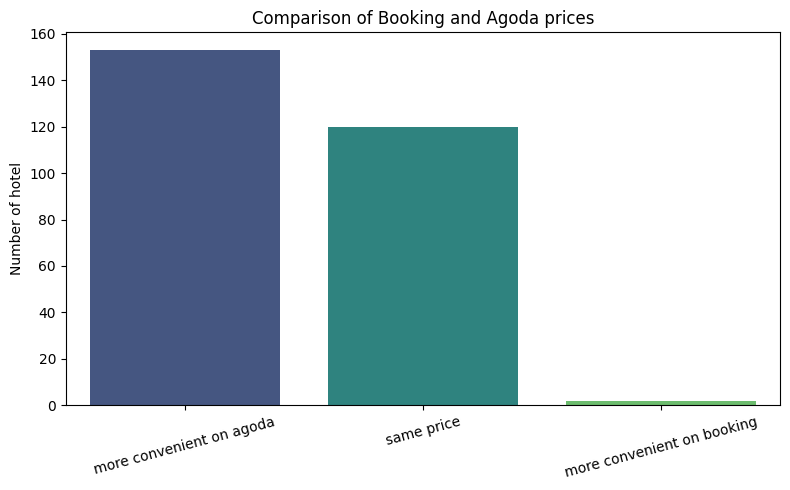

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Conta quante volte ciascuna etichetta appare
conteggio_convenienza = matches_df_2_new['convenienza'].value_counts().reset_index()
conteggio_convenienza.columns = ['Portale più conveniente', 'Numero di hotel']

# Grafico
plt.figure(figsize=(8, 5))
sns.barplot(data=conteggio_convenienza, x='Portale più conveniente', y='Numero di hotel', palette='viridis')
plt.title('Comparison of Booking and Agoda prices')
plt.ylabel('Number of hotel')
plt.xlabel('')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the mean of the 'differenza_percentuale' column
media_differenza_percentuale = matches_df_2_new['differenza_percentuale'].mean()

# Print the result
print(f"La media della variabile 'differenza_percentuale' è: {media_differenza_percentuale}")

La media della variabile 'differenza_percentuale' è: 10.289806219110133


In [ ]:
# Differenza
matches_df_2_new['differenza'] = matches_df_2_new['prezzo_booking'] - matches_df_2_new['prezzo_agoda']
matches_df_2_new['differenza_assoluta'] = matches_df_2_new['differenza'].abs()

# Booking più caro
piu_caro_booking = matches_df_2_new[matches_df_2_new['differenza'] > 0]
# Agoda più caro
piu_caro_agoda = matches_df_2_new[matches_df_2_new['differenza'] < 0]

# Esempi
print("\nEsempi dove Booking è più caro:")
print(piu_caro_booking[['titolo_booking', 'prezzo_booking', 'prezzo_agoda', 'differenza']].head())

print("\nEsempi dove Agoda è più caro:")
print(piu_caro_agoda[['titolo_booking', 'prezzo_booking', 'prezzo_agoda', 'differenza']].head())

# Media delle differenze
media_diff = matches_df_2_new['differenza'].mean()
media_diff_assoluta = matches_df_2_new['differenza'].abs().mean()

print(f"\nIn media Booking è più caro di {media_diff:.2f} euro (positivo significa Booking più caro).")
print(f"In media la differenza assoluta è di {media_diff_assoluta:.2f} euro.")



Esempi dove Booking è più caro:
                    titolo_booking  prezzo_booking  prezzo_agoda  differenza
284  boutique campo de fiori hotel           499.0         470.0        29.0
283                 hotel napoleon           256.0         122.0       134.0
267             artistes des hotel           210.0         170.0        40.0
265             frattina residenza           210.0         172.0        38.0
264                 41 hotel trevi           210.0         177.0        33.0

Esempi dove Agoda è più caro:
                                       titolo_booking  prezzo_booking  \
64  capriolo con del dimora e favolosa giardino pa...           216.0   
86                   campo de fiori spanish suite the           255.0   

    prezzo_agoda  differenza  
64         228.0       -12.0  
86         316.0       -61.0  

In media Booking è più caro di 22.84 euro (positivo significa Booking più caro).
In media la differenza assoluta è di 23.37 euro.


In [ ]:
matches_df_2_new['percentuale_diff'] = (matches_df_2_new['differenza'] / matches_df_2_new['prezzo_booking']) * 100
media_percentuale_diff = matches_df_2_new['percentuale_diff'].mean()
media_percentuale_diff_assoluta = matches_df_2_new['percentuale_diff'].abs().mean()
print(f"In media Agoda è più conveniente del {abs(media_percentuale_diff):.2f}% rispetto a Booking (segno positivo = Booking più caro).")
print(f"In media la differenza percentuale assoluta è del {media_percentuale_diff_assoluta:.2f}%.")


In media Agoda è più conveniente del 10.29% rispetto a Booking (segno positivo = Booking più caro).
In media la differenza percentuale assoluta è del 10.50%.


In [ ]:
#questaaaaaaaaaaa
import pandas as pd

# Supponiamo che matches_df_2_new sia già caricato
# matches_df_2_new = pd.read_csv("tuo_file.csv")

# Calcola la differenza di prezzo per ciascun record
matches_df_2_new["differenza_prezzo"] = matches_df_2_new["prezzo_agoda"] - matches_df_2_new["prezzo_booking"]

# Calcola la media della differenza
media_differenza = matches_df_2_new["differenza_prezzo"].mean()

# Calcola la percentuale media di differenza rispetto al prezzo booking
matches_df_2_new["percentuale_differenza"] = matches_df_2_new["differenza_prezzo"] / matches_df_2_new["prezzo_booking"] * 100

# Media della percentuale
media_percentuale = matches_df_2_new["percentuale_differenza"].mean()

print(f"La differenza media di prezzo è {media_differenza:.2f} euro.")
print(f"La differenza media percentuale è {media_percentuale:.2f}%.")


La differenza media di prezzo è -22.84 euro.
La differenza media percentuale è -10.29%.


In [ ]:
# Raggruppa per città e calcola la media dei prezzi su Agoda e Booking
prezzi_medi = matches_df_2_new.groupby('città_agoda')[['prezzo_agoda', 'prezzo_booking']].mean()

print(prezzi_medi)


             prezzo_agoda  prezzo_booking
città_agoda                              
roma           193.777251      223.464455
terni           99.046875       99.328125


# individua outliers

In [ ]:
def trova_outlier_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # restituisce un booleano: True se è outlier
    return (series < lower_bound) | (series > upper_bound)

# Trova outlier su entrambe le colonne
outlier_agoda = trova_outlier_iqr(matches_df_2_new['prezzo_agoda'])
outlier_booking = trova_outlier_iqr(matches_df_2_new['prezzo_booking'])

# Tutti gli outlier (su almeno una delle due colonne)
outliers = outlier_agoda | outlier_booking

print(f"Numero totale outlier: {outliers.sum()}")

# Mostra gli outlier
print(matches_df_2_new[outliers])


Numero totale outlier: 15
     index_booking  index_agoda  id_booking  id_agoda  \
284            881          652         881       652   
256            777          140         777       140   
72             103          667         103       667   
69              97          624          97       624   
89             210          556         210       556   
93             222          380         222       380   
110            297          552         297       552   
109            292          292         292       292   
133            371          658         371       658   
149            433          660         433       660   
156            451          553         451       553   
187            562          269         562       269   
183            551          412         551       412   
200            610          558         610       558   
273            839          411         839       411   

                                        titolo_booking  \
284

In [ ]:
# Dataframe senza outlier
df_senza_outlier = matches_df_2_new[~outliers]

# Calcolo prezzi medi senza outlier
prezzi_medi_no_outlier = df_senza_outlier.groupby('città_agoda')[['prezzo_agoda', 'prezzo_booking']].mean()

print(prezzi_medi_no_outlier)


             prezzo_agoda  prezzo_booking
città_agoda                              
roma           171.494898      200.219388
terni           99.046875       99.328125
